<h1 align='center'> Analyzing & Clustering Bengaluru POI data from OSM </h1>

## Importing Libraries

In [272]:
import numpy as np
import pandas as pd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Loading Bengaluru POI data extracted from OSM into pandas dataframe

In [273]:
df = pd.read_csv("bengaluru_geo_data.csv")

### Let's analyze the data

In [274]:
df.shape

(6879, 5)

In [275]:
df.head()

id    category sub_category        lat        lon
0  346745629  sustenance          bar  12.960247  77.646907
1  347188390  sustenance          bar  12.933091  77.630678
2  351811154  sustenance          bar  13.002424  77.633937
3  609903172  sustenance          bar  12.912950  77.683123
4  181695452  sustenance         cafe  12.979373  77.714872

#### Setting geographical coordinates of Bengaluru City

In [281]:
latitude = 12.9791198 
longitude = 77.5912997
print('The geograpical coordinate of Bangalore City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore City are 12.9791198, 77.5912997.


#### The dataset is huge, so let's take a sample of dataset for visualizing the dataset

In [278]:
# Taking sample of df for plotting 
tf = df.sample(n=300)

In [9]:
tf.shape

(300, 5)

## Visualizing Using Matplotlib

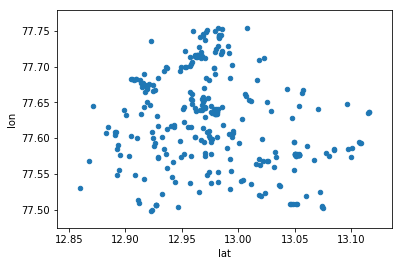

In [13]:
tf.plot('lat', 'lon', kind='scatter')

## Visualizing Using Folium

Let's use folium for more interactive visualization

In [282]:
# create map of Bangalore using latitude and longitude values
map_bng = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, ctg, s_ctg in zip(tf['lat'], tf['lon'], tf['category'], tf['sub_category']):
    label = '{}, {}'.format(ctg, s_ctg)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bng)  
    
map_bng

## Let's create geo-dataframe for our data using geopandas library

In [284]:
import geopandas

In [285]:
coords = []
df.apply(lambda x: coords.append([x.lat, x.lon]), axis=1)
coordinates = np.array(coords)

In [286]:
coordinates[:5]

array([[12.9602467, 77.6469068],
       [12.9330907, 77.6306778],
       [13.0024235, 77.6339368],
       [12.9129499, 77.6831231],
       [12.9793732, 77.7148716]])

In [287]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

In [288]:
gdf.head()

id    category sub_category        lat        lon  \
0  346745629  sustenance          bar  12.960247  77.646907   
1  347188390  sustenance          bar  12.933091  77.630678   
2  351811154  sustenance          bar  13.002424  77.633937   
3  609903172  sustenance          bar  12.912950  77.683123   
4  181695452  sustenance         cafe  12.979373  77.714872   

                    geometry  
0  POINT (77.64691 12.96025)  
1  POINT (77.63068 12.93309)  
2  POINT (77.63394 13.00242)  
3  POINT (77.68312 12.91295)  
4  POINT (77.71487 12.97937)

## Clustering POI data based on category

#### Let's prepare data for clustering

In [290]:
x = gdf.copy()[['category', 'geometry']]
x.head()

category                   geometry
0  sustenance  POINT (77.64691 12.96025)
1  sustenance  POINT (77.63068 12.93309)
2  sustenance  POINT (77.63394 13.00242)
3  sustenance  POINT (77.68312 12.91295)
4  sustenance  POINT (77.71487 12.97937)

#### Performing one hot encoding on Categorical data

In [291]:
x['category'] = pd.Categorical(x['category'])
dfDummies = pd.get_dummies(x['category'])
x = pd.concat([x, dfDummies], axis=1)

In [293]:
x.head()

category                   geometry  accomodation  agriculture  \
0  sustenance  POINT (77.64691 12.96025)             0            0   
1  sustenance  POINT (77.63068 12.93309)             0            0   
2  sustenance  POINT (77.63394 13.00242)             0            0   
3  sustenance  POINT (77.68312 12.91295)             0            0   
4  sustenance  POINT (77.71487 12.97937)             0            0   

   commercial  education  entertainment  healthcare  historic  religious  \
0           0          0              0           0         0          0   
1           0          0              0           0         0          0   
2           0          0              0           0         0          0   
3           0          0              0           0         0          0   
4           0          0              0           0         0          0   

   sustenance  tourism  
0           1        0  
1           1        0  
2           1        0  
3           1        0  
4           1        0

### We will cluster the data based on the category of POI

In [292]:
inp = x.drop(['category', 'geometry'], axis=1)
inp.head()

accomodation  agriculture  commercial  education  entertainment  \
0             0            0           0          0              0   
1             0            0           0          0              0   
2             0            0           0          0              0   
3             0            0           0          0              0   
4             0            0           0          0              0   

   healthcare  historic  religious  sustenance  tourism  
0           0         0          0           1        0  
1           0         0          0           1        0  
2           0         0          0           1        0  
3           0         0          0           1        0  
4           0         0          0           1        0

### We will use K-Means clustering so let's find best k value using elbow method

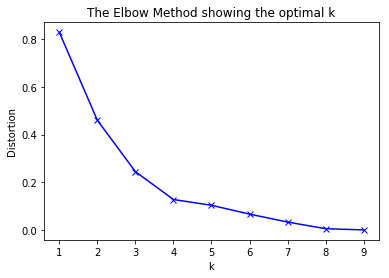

In [294]:
# determine k using elbow method

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
# plt.plot()
X = inp
# colors = ['b', 'g', 'r']
# markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Let's use k=4, as it seems to the optimal value of k based on elbow method

### Clustering using K-Means with k=4

In [302]:
# set number of clusters
kclusters = 4

bng_clustering = inp

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bng_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Let's create a new dataframe with cluster_labels

In [303]:
# create a new dataframe that includes cluster label
bng_merged = df.copy()

# add clustering labels
bng_merged["cluster"] = kmeans.labels_

#### Sampling the new dataframe for visualization

In [304]:
# Creating sample for visualisation
bng_sample = bng_merged.sample(n = 300)

### Visualizing clustered Data based on POI category

In [305]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bng_sample['lat'], bng_sample['lon'], bng_sample['category'], bng_sample['cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Let's save the dataframe with cluster_labels

In [306]:
bng_merged.to_csv('bng_category_cluster.csv', index=False)

## Analyzing Clusters

### Cluster 1

In [307]:
cluster_1 = bng_merged.loc[bng_merged['cluster'] == 0]
cluster_1.groupby('category').id.count()

category
agriculture      2
education      604
healthcare     177
historic        16
religious       80
sustenance     132
tourism        130
Name: id, dtype: int64

In [308]:
cluster_1.sample(10)

id    category  sub_category        lat        lon  \
890   331692841  healthcare        clinic  12.978028  77.634281   
511   219381382   education        school  12.976222  77.539339   
6754   38870571     tourism       tourism  12.992270  77.581884   
393    51132139   education        school  13.032937  77.651473   
731   159766768   education  kindergarten  12.970217  77.747984   
329   628739078   education       college  13.123999  77.620464   
866   513532062  healthcare      hospital  13.006620  77.552964   
416   114786334   education        school  13.004750  77.564191   
6742  400433089    historic      historic  13.012618  77.582268   
678   668612959   education        school  12.872888  77.597586   

                       geometry  cluster  
890   POINT (77.63428 12.97803)        0  
511   POINT (77.53934 12.97622)        0  
6754  POINT (77.58188 12.99227)        0  
393   POINT (77.65147 13.03294)        0  
731   POINT (77.74798 12.97022)        0  
329   POINT (77.62046 13.12400)        0  
866   POINT (77.55296 13.00662)        0  
416   POINT (77.56419 13.00475)        0  
6742  POINT (77.58227 13.01262)        0  
678   POINT (77.59759 12.87289)        0

#### Cluster 1 Observation
This cluster conatins POIs related to
* agriculture
* education      
* healthcare     
* historic       
* religious       
* sustenance     
* tourism 

All the POIs in these categories were in minority as compared to other categories. This is the cluster of all these minority categories.

### Cluster 2

In [310]:
cluster_2 = bng_merged.loc[bng_merged['cluster'] == 1]
cluster_2.groupby('category').id.count()

category
accomodation    2956
Name: id, dtype: int64

In [316]:
cluster_2.sample(10)

id      category sub_category        lat        lon  \
3021  259895236  accomodation   apartments  12.953131  77.715470   
4439  447114966  accomodation        house  13.106993  77.591979   
5283  331338681  accomodation  residential  12.978558  77.635644   
3416  398905980  accomodation   apartments  13.045467  77.500245   
4623  511184460  accomodation        house  12.960757  77.714205   
3211  347130880  accomodation   apartments  12.908895  77.553612   
5649  685702954  accomodation  residential  12.968033  77.646326   
3202  347116171  accomodation   apartments  12.924709  77.652791   
3678  609974362  accomodation   apartments  12.903303  77.684718   
4730  609881593  accomodation        house  12.908129  77.681680   

                       geometry  cluster  
3021  POINT (77.71547 12.95313)        1  
4439  POINT (77.59198 13.10699)        1  
5283  POINT (77.63564 12.97856)        1  
3416  POINT (77.50024 13.04547)        1  
4623  POINT (77.71421 12.96076)        1  
3211  POINT (77.55361 12.90890)        1  
5649  POINT (77.64633 12.96803)        1  
3202  POINT (77.65279 12.92471)        1  
3678  POINT (77.68472 12.90330)        1  
4730  POINT (77.68168 12.90813)        1

#### Cluster 2 Observation
This cluster conatins POIs related to **Accomodation**

### Cluster 3

In [317]:
cluster_3 = bng_merged.loc[bng_merged['cluster'] == 2]
cluster_3.groupby('category').id.count()

category
commercial    926
Name: id, dtype: int64

In [318]:
cluster_3.sample(10)

id    category sub_category        lat        lon  \
6082  378507978  commercial   commercial  12.974242  77.608428   
6261  635487458  commercial   commercial  13.067182  77.586056   
6629  364740191  commercial    warehouse  12.989213  77.768437   
6323  726171342  commercial   commercial  13.061201  77.507127   
6247  614485333  commercial   commercial  12.962477  77.713211   
5814  286438316  commercial   commercial  12.910372  77.599711   
6648  676038917  commercial    warehouse  13.007754  77.665210   
6231  611516373  commercial   commercial  12.913088  77.679340   
6104  383645144  commercial   commercial  12.925644  77.682915   
6420  313854313  commercial   industrial  12.933044  77.602068   

                       geometry  cluster  
6082  POINT (77.60843 12.97424)        2  
6261  POINT (77.58606 13.06718)        2  
6629  POINT (77.76844 12.98921)        2  
6323  POINT (77.50713 13.06120)        2  
6247  POINT (77.71321 12.96248)        2  
5814  POINT (77.59971 12.91037)        2  
6648  POINT (77.66521 13.00775)        2  
6231  POINT (77.67934 12.91309)        2  
6104  POINT (77.68291 12.92564)        2  
6420  POINT (77.60207 12.93304)        2

#### Cluster 3 Observation
This cluster conatins POIs related to **Commercial**

### Cluster 4

In [319]:
cluster_4 = bng_merged.loc[bng_merged['cluster'] == 3]
cluster_4.groupby('category').id.count()

category
entertainment    1856
Name: id, dtype: int64

In [320]:
cluster_4.sample(10)

id       category sub_category        lat        lon  \
1102   52059217  entertainment      leisure  12.976545  77.597290   
2218  464921469  entertainment      leisure  13.035922  77.534057   
2434  583442700  entertainment      leisure  13.028603  77.560080   
1246  133751578  entertainment      leisure  12.865083  77.612893   
1949  363378793  entertainment      leisure  13.115151  77.635744   
1645  313831699  entertainment      leisure  12.917562  77.629142   
1204  130630617  entertainment      leisure  12.943155  77.746560   
2421  582562272  entertainment      leisure  12.975793  77.705803   
1542  227014069  entertainment      leisure  13.098696  77.571793   
1842  360101202  entertainment      leisure  12.980077  77.635987   

                       geometry  cluster  
1102  POINT (77.59729 12.97654)        3  
2218  POINT (77.53406 13.03592)        3  
2434  POINT (77.56008 13.02860)        3  
1246  POINT (77.61289 12.86508)        3  
1949  POINT (77.63574 13.11515)        3  
1645  POINT (77.62914 12.91756)        3  
1204  POINT (77.74656 12.94316)        3  
2421  POINT (77.70580 12.97579)        3  
1542  POINT (77.57179 13.09870)        3  
1842  POINT (77.63599 12.98008)        3

#### Cluster 4 Observation
This cluster conatins POIs related to **Entertainment**

<hr>

## Commercial Centers/Clusters of Bangalore

Now we know that cluster 3 conatins all the POI related to commercial category. So, we will use POIs in cluster 3 for further analysis

### Visualizing commercial POIs

In [325]:
# Cluster 3 is commercial
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster_3['lat'], cluster_3['lon'], cluster_3['category'], cluster_3['cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Clustering Commercial POIs based on geolocation using HDBSCAN

HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. 

We are using HDBSCAN as it has an option to use Haversine as metric, which is suitable for clustering geo-spatial data.

In [335]:
import hdbscan

In [336]:
coords = []
cluster_3.apply(lambda x: coords.append([x.lat, x.lon]), axis=1)
coordinates = np.array(coords)
coordinates[:5]

array([[12.9732547, 77.6146166],
       [12.9727223, 77.6143913],
       [12.9904423, 77.7302358],
       [12.9328153, 77.6146363],
       [12.9529353, 77.6415305]])

In [343]:
rads = np.radians(coordinates)
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='haversine')
cluster_labels = clusterer.fit_predict(rads)

### Adding new cluster_labels based on clustering based on geo-location

In [344]:
df2 = cluster_3.copy()
df2['cluster'] = cluster_labels
df2.head()

id    category sub_category        lat        lon  \
5725   53264751  commercial   commercial  12.973255  77.614617   
5726   53264752  commercial   commercial  12.972722  77.614391   
5727   91003802  commercial   commercial  12.990442  77.730236   
5728   93697573  commercial   commercial  12.932815  77.614636   
5729  104573380  commercial   commercial  12.952935  77.641531   

                       geometry  cluster  
5725  POINT (77.61462 12.97325)       42  
5726  POINT (77.61439 12.97272)       42  
5727  POINT (77.73024 12.99044)       -1  
5728  POINT (77.61464 12.93282)       35  
5729  POINT (77.64153 12.95294)       43

### Visualizing Commercial Clusters

In [345]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(set(cluster_labels)))
ys = [i+x+(i*x)**2 for i in range(len(set(cluster_labels)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2['lat'], df2['lon'], df2['sub_category'], df2['cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Rremoving Outliers

Currently there are outliers that don't belong to any cluster let's remove such outliers. Outliers are labelled as -1 by hdbscan.

In [347]:
cl_df = df2.loc[df2['cluster'] != -1]
cl_df.head()

id    category sub_category        lat        lon  \
5725   53264751  commercial   commercial  12.973255  77.614617   
5726   53264752  commercial   commercial  12.972722  77.614391   
5728   93697573  commercial   commercial  12.932815  77.614636   
5729  104573380  commercial   commercial  12.952935  77.641531   
5730  105322136  commercial   commercial  12.949349  77.644745   

                       geometry  cluster  
5725  POINT (77.61462 12.97325)       42  
5726  POINT (77.61439 12.97272)       42  
5728  POINT (77.61464 12.93282)       35  
5729  POINT (77.64153 12.95294)       43  
5730  POINT (77.64475 12.94935)       43

## Visualizing Commercial Clusters of Bengaluru after removing Outliers

In [348]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(set(cluster_labels)))
ys = [i+x+(i*x)**2 for i in range(len(set(cluster_labels)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cl_df['lat'], cl_df['lon'], cl_df['sub_category'], cl_df['cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Saving Commerecial Clusters as a CSV file

In [349]:
cl_df.to_csv('commercial_cluster.csv', index=False)

<hr>

## Calculating Commercial Cluster boundaries(polygon) & Creating ESRI Shapefile

#### Importing required libraries 

In [351]:
from shapely.ops import cascaded_union, polygonize
import shapely.geometry as geometry
from scipy.spatial import Delaunay
from descartes import PolygonPatch
import pylab as pl
import numpy as np
import math

print('Imported libaries')

Imported libaries


### Function to Calculate Concave hull(polygon)

In [352]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0]
                       for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points


### Function to plot polygons

In [365]:

def plot_polygon(polygon):
    fig = pl.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

### Let's Create a dictionary of all clusters

In [386]:
clusters = {}
for i in set(cluster_labels):
    if i != -1:
        clusters[f'cluster_{i}']=df2.loc[df2['cluster'] == i]

In [387]:
len(clusters)

52

In [388]:
clusters.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36', 'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46', 'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51'])

### Let's assign a tag to each cluster
We will tag the cluster based on the sub_category of the POIs in the cluster.
Tag Name = Sub_category(with max POI in the cluster)

In [391]:
def get_tag(df):
    """
    Function to assign tag to cluster based on sub_category
    """
    t = df.groupby('sub_category')[['id']].count()
    tag = t[t['id'] == t.id.max()].index.values[0]
    
    return tag

In [394]:
tags = [ get_tag(df) for df in clusters.values() ]

### Let's try to find to find cluster polygon for one Cluster

In [395]:
cl = cl_df.loc[cl_df['cluster'] == 10]
cl.groupby('sub_category').id.count()

sub_category
commercial    14
office         1
retail         2
Name: id, dtype: int64

In [396]:
coords = []
cl.apply(lambda x: coords.append([x.lat, x.lon]), axis=1)
coordinates = np.array(coords)
coordinates[:5]

array([[13.0122554, 77.5561753],
       [12.9950317, 77.5526663],
       [13.001772 , 77.5695586],
       [12.9896312, 77.5547175],
       [13.0001618, 77.5503768]])

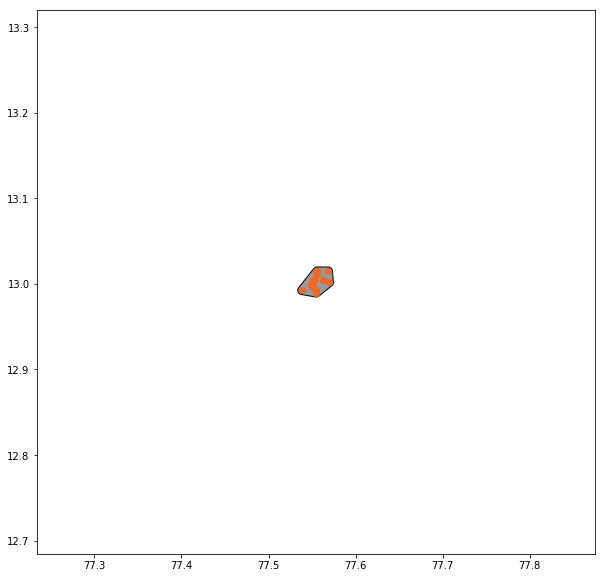

In [397]:
concave_hull, edge_points = alpha_shape(cl.geometry, alpha=0.4)
_ = plot_polygon(concave_hull.buffer(0.005))
_ = pl.plot(cl.lon,cl.lat,'o', color='#f16824')

In [398]:
print(concave_hull)

POLYGON ((77.55471750000001 12.9896312, 77.53855009999999 12.9925381, 77.55592920000001 13.014803, 77.5684677 13.0147325, 77.56955859999999 13.001772, 77.55471750000001 12.9896312))


In [399]:
type(concave_hull)

shapely.geometry.polygon.Polygon

### Let's find Polygons for each cluster and store it in a dictionary

In [400]:
polygons = {}
for key, val in zip(clusters.keys(), clusters.values()) :
    concave_hull, _ = alpha_shape(val.geometry, alpha=0.4)
    polygons[key] = concave_hull

In [401]:
polygons.keys()

dict_keys(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32', 'cluster_33', 'cluster_34', 'cluster_35', 'cluster_36', 'cluster_37', 'cluster_38', 'cluster_39', 'cluster_40', 'cluster_41', 'cluster_42', 'cluster_43', 'cluster_44', 'cluster_45', 'cluster_46', 'cluster_47', 'cluster_48', 'cluster_49', 'cluster_50', 'cluster_51'])

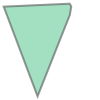

In [402]:
polygons['cluster_0']

In [403]:
print(polygons['cluster_0'])

POLYGON ((77.5973231 13.0955973, 77.58605559999999 13.067182, 77.5742608 13.0984214, 77.5972342 13.0994416, 77.59779279999999 13.0984931, 77.5973231 13.0955973))


### Creating a pandas dataframe to store Clusters with it's bounding polygon

In [404]:
poly_df = pd.DataFrame({'cluster': list(polygons.keys()), 'geometry': list(polygons.values())})

### Converting the pandas dataframe to geopandas dataframe for further operations

In [409]:
poly_gdf = geopandas.GeoDataFrame( poly_df, geometry=poly_df.geometry)
poly_gdf.head()

cluster                                           geometry
0  cluster_0  POLYGON ((77.59732 13.09560, 77.58606 13.06718...
1  cluster_1  POLYGON ((77.61988 13.04357, 77.57503 13.05340...
2  cluster_2  POLYGON ((77.51413 12.92905, 77.50164 12.93474...
3  cluster_3  POLYGON ((77.61155 12.88731, 77.61273 12.87654...
4  cluster_4  POLYGON ((77.50500 13.07388, 77.50387 13.07165...

### Adding tag to each cluster

In [410]:
poly_gdf['tag'] = tags
poly_gdf.head()

cluster                                           geometry         tag
0  cluster_0  POLYGON ((77.59732 13.09560, 77.58606 13.06718...  commercial
1  cluster_1  POLYGON ((77.61988 13.04357, 77.57503 13.05340...      office
2  cluster_2  POLYGON ((77.51413 12.92905, 77.50164 12.93474...  commercial
3  cluster_3  POLYGON ((77.61155 12.88731, 77.61273 12.87654...  commercial
4  cluster_4  POLYGON ((77.50500 13.07388, 77.50387 13.07165...  commercial

### Adding Coordinate Reference Systems (CRS)
CRS are important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth.

CRS are referred to using codes called proj4 strings. You can find the codes for most commonly used projections from www.spatialreference.org.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. One proj4 representation of this projection is: "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs". But common projections can also be referred to by EPSG codes, so this same projection can also called using the proj4 string "+init=epsg:4326".

geopandas can accept lots of representations of CRS, including the proj4 string itself ("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs") or parameters broken out in a dictionary: {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}). In addition, some functions will take EPSG codes directly.

In [411]:
poly_gdf.crs = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [221]:
# schema = {'geometry': 'Polygon', 'properties': {'cluster': 'str', 'tag': 'str'}}

### Creating ESRI Shapefile to store Commercial Cluster data

In [413]:
poly_gdf.to_file('bengaluru_commercial_clusters.shp', driver='ESRI Shapefile')

<hr>